The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0


# Convexity
:label:`sec_convexity`

Convexity plays a vital role in the design of optimization algorithms. This is largely due to the fact that it is much easier to analyze and test algorithms in this context. In other words, if the algorithm performs poorly even in the convex setting we should not hope to see great results otherwise. Furthermore, even though the optimization problems in deep learning are generally nonconvex, they often exhibit some properties of convex ones near local minima. This can lead to exciting new optimization variants such as :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`.

## Basics

Let us begin with the basics.

### Sets

Sets are the basis of convexity. Simply put, a set $X$ in a vector space is convex if for any $a, b \in X$ the line segment connecting $a$ and $b$ is also in $X$. In mathematical terms this means that for all $\lambda \in [0, 1]$ we have

$$\lambda \cdot a + (1-\lambda) \cdot b \in X \text{ whenever } a, b \in X.$$

This sounds a bit abstract. Consider the picture :numref:`fig_pacman`. The first set is not convex since there are line segments that are not contained in it. The other two sets suffer no such problem.

![Three shapes, the left one is nonconvex, the others are convex](http://d2l.ai/_images/pacman.svg)
:label:`fig_pacman`

Definitions on their own are not particularly useful unless you can do something with them. In this case we can look at unions and intersections as shown in :numref:`fig_convex_intersect`. Assume that $X$ and $Y$ are convex sets. Then $X \cap Y$ is also convex. To see this, consider any $a, b \in X \cap Y$. Since $X$ and $Y$ are convex, the line segments connecting $a$ and $b$ are contained in both $X$ and $Y$. Given that, they also need to be contained in $X \cap Y$, thus proving our first theorem.

![The intersection between two convex sets is convex](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

We can strengthen this result with little effort: given convex sets $X_i$, their intersection $\cap_{i} X_i$ is convex.
To see that the converse is not true, consider two disjoint sets $X \cap Y = \emptyset$. Now pick $a \in X$ and $b \in Y$. The line segment in :numref:`fig_nonconvex` connecting $a$ and $b$ needs to contain some part that is neither in $X$ nor $Y$, since we assumed that $X \cap Y = \emptyset$. Hence the line segment is not in $X \cup Y$ either, thus proving that in general unions of convex sets need not be convex.

![The union of two convex sets need not be convex](http://d2l.ai/_images/nonconvex.svg)
:label:`fig_nonconvex`

Typically the problems in deep learning are defined on convex domains. For instance $\mathbb{R}^d$ is a convex set (after all, the line between any two points in $\mathbb{R}^d$ remains in $\mathbb{R}^d$). In some cases we work with variables of bounded length, such as balls of radius $r$ as defined by $\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_2 \leq r\}$.

### Functions

Now that we have convex sets we can introduce convex functions $f$. Given a convex set $X$ a function defined on it $f: X \to \mathbb{R}$ is convex if for all $x, x' \in X$ and for all $\lambda \in [0, 1]$ we have

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

To illustrate this let us plot a few functions and check which ones satisfy the requirement. We need to import a few  libraries.


In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mpl_toolkits import mplot3d
from mxnet import np, npx
npx.set_np()

Let us define a few functions, both convex and nonconvex.


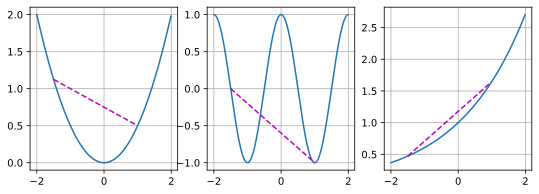

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: np.cos(np.pi * x)  # Nonconvex
h = lambda x: np.exp(0.5 * x)  # Convex

x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

As expected, the cosine function is nonconvex, whereas the parabola and the exponential function are. Note that the requirement that $X$ is a convex set is necessary for the condition to make sense. Otherwise the outcome of $f(\lambda x + (1-\lambda) x')$ might not be well defined. Convex functions have a number of desirable properties.

### Jensen's Inequality

One of the most useful tools is Jensen's inequality. It amounts to a generalization of the definition of convexity:

$$\begin{aligned}
    \sum_i \alpha_i f(x_i) & \geq f\left(\sum_i \alpha_i x_i\right)
    \text{ and }
    E_x[f(x)] & \geq f\left(E_x[x]\right),
\end{aligned}$$

where $\alpha_i$ are nonnegative real numbers such that $\sum_i \alpha_i = 1$. In other words, the expectation of a convex function is larger than the convex function of an expectation. To prove the first inequality we repeatedly apply the definition of convexity to one term in the sum at a time. The expectation can be proven by taking the limit over finite segments.

One of the common applications of Jensen's inequality is with regard to the log-likelihood of partially observed random variables. That is, we use

$$E_{y \sim P(y)}[-\log P(x \mid y)] \geq -\log P(x).$$

This follows since $\int P(y) P(x \mid y) dy = P(x)$.
This is used in variational methods. Here $y$ is typically the unobserved random variable, $P(y)$ is the best guess of how it might be distributed and $P(x)$ is the distribution with $y$ integrated out. For instance, in clustering $y$ might be the cluster labels and $P(x \mid y)$ is the generative model when applying cluster labels.


## Properties

Convex functions have a few useful properties. We describe them as follows.


### Local Minima is Global Minima

In particular, the local minima for convex functions is also the global minima. Let us assume the contrary and prove it wrong. If $x^{\ast} \in X$ is a local minimum such that there is a small positive value $p$ so that for $x \in X$ that satisfies $0 < |x - x^{\ast}| \leq p$ there is $f(x^{\ast}) < f(x)$. Assume there exists $x' \in X$ for which $f(x') < f(x^{\ast})$. According to the property of convexity, 

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &< f(x^{\ast}) \\
\end{aligned}$$

There exists $\lambda \in [0, 1)$, $\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$ for an example, so that $0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$. However, because $f(\lambda x^{\ast} + (1-\lambda) x') < f(x^{\ast})$, this violates our local minimum statement. Therefore, there does not exist $x' \in X$ for which $f(x') < f(x^{\ast})$. The local minimum $x^{\ast}$ is also the global minimum.

For instance, the function $f(x) = (x-1)^2$ has a local minimum for $x=1$, it is also the global minimum.


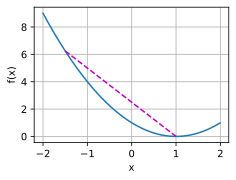

In [3]:
f = lambda x: (x-1)**2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

The fact that the local minima for convex functions is also the global minima is very convenient. It means that if we minimize functions we cannot "get stuck". Note, though, that this does not mean that there cannot be more than one global minimum or that there might even exist one. For instance, the function $f(x) = \mathrm{max}(|x|-1, 0)$ attains its minimum value over the interval $[-1, 1]$. Conversely, the function $f(x) = \exp(x)$ does not attain a minimum value on $\mathbb{R}$. For $x \to -\infty$ it asymptotes to $0$, however there is no $x$ for which $f(x) = 0$.

### Convex Functions and Sets

Convex functions define convex sets as *below-sets*. They are defined as

$$S_b := \{x | x \in X \text{ and } f(x) \leq b\}.$$

Such sets are convex. Let us prove this quickly. Remember that for any $x, x' \in S_b$ we need to show that $\lambda x + (1-\lambda) x' \in S_b$ as long as $\lambda \in [0, 1]$. But this follows directly from the definition of convexity since $f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b$.

Have a look at the function $f(x, y) = 0.5 x^2 + \cos(2 \pi y)$ below. It is clearly nonconvex. The level sets are correspondingly nonconvex. In fact, they are typically composed of disjoint sets.


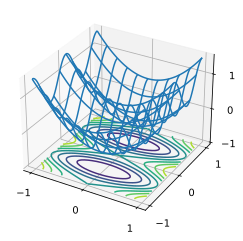

In [4]:
x, y = np.meshgrid(
    np.linspace(-1.0, 1.0, 101), np.linspace(-1.0, 1.0, 101))
z = x**2 + 0.5 * np.cos(2 * np.pi * y)
# Plot the 3D surface
d2l.set_figsize((6, 4))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.contour(x, y, z, offset=-1)
ax.set_zlim(-1, 1.5)
# Adjust labels
for func in [d2l.plt.xticks, d2l.plt.yticks, ax.set_zticks]:
    func([-1, 0, 1])

### Derivatives and Convexity

Whenever the second derivative of a function exists it is very easy to check for convexity. All we need to do is check whether $\partial_x^2 f(x) \succeq 0$, i.e., whether all of its eigenvalues are nonnegative. For instance, the function $f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2_2$ is convex since $\partial_{\mathbf{x}}^2 f = \mathbf{1}$, i.e., its derivative is the identity matrix.

The first thing to realize is that we only need to prove this property for one-dimensional functions. After all, in general we can always define some function $g(z) = f(\mathbf{x} + z \cdot \mathbf{v})$. This function has the first and second derivatives $g' = (\partial_{\mathbf{x}} f)^\top \mathbf{v}$ and $g'' = \mathbf{v}^\top (\partial^2_{\mathbf{x}} f) \mathbf{v}$ respectively. In particular, $g'' \geq 0$ for all $\mathbf{v}$ whenever the Hessian of $f$ is positive semidefinite, i.e., whenever all of its eigenvalues are greater equal than zero. Hence back to the scalar case.

To see that $f''(x) \geq 0$ for convex functions we use the fact that

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

Since the second derivative is given by the limit over finite differences it follows that

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

To see that the converse is true we use the fact that $f'' \geq 0$ implies that $f'$ is a monotonically increasing function. Let $a < x < b$ be three points in $\mathbb{R}$. We use the mean value theorem to express

$$\begin{aligned}
f(x) - f(a) & = (x-a) f'(\alpha) \text{ for some } \alpha \in [a, x] \text{ and } \\
f(b) - f(x) & = (b-x) f'(\beta) \text{ for some } \beta \in [x, b].
\end{aligned}$$

By monotonicity $f'(\beta) \geq f'(\alpha)$, hence

$$\begin{aligned}
    f(b) - f(a) & = f(b) - f(x) + f(x) - f(a) \\
    & = (b-x) f'(\beta) + (x-a) f'(\alpha) \\
    & \geq (b-a) f'(\alpha).
\end{aligned}$$

By geometry it follows that $f(x)$ is below the line connecting $f(a)$ and $f(b)$, thus proving convexity. We omit a more formal derivation in favor of a graph below.


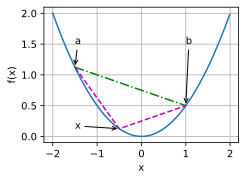

In [5]:
f = lambda x: 0.5 * x**2
x = np.arange(-2, 2, 0.01)
axb, ab = np.array([-1.5, -0.5, 1]), np.array([-1.5, 1])
d2l.set_figsize()
d2l.plot([x, axb, ab], [f(x) for x in [x, axb, ab]], 'x', 'f(x)')
d2l.annotate('a', (-1.5, f(-1.5)), (-1.5, 1.5))
d2l.annotate('b', (1, f(1)), (1, 1.5))
d2l.annotate('x', (-0.5, f(-0.5)), (-1.5, f(-0.5)))

## Constraints

One of the nice properties of convex optimization is that it allows us to handle constraints efficiently. That is, it allows us to solve problems of the form:

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

Here $f$ is the objective and the functions $c_i$ are constraint functions. To see what this does consider the case where $c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$. In this case the parameters $\mathbf{x}$ are constrained to the unit ball. If a second constraint is $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$, then this corresponds to all $\mathbf{x}$ lying on a halfspace. Satisfying both constraints simultaneously amounts to selecting a slice of a ball as the constraint set.

### Lagrange Function

In general, solving a constrained optimization problem is difficult. One way of addressing it stems from physics with a rather simple intuition. Imagine a ball inside a box. The ball will roll to the place that is lowest and the forces of gravity will be balanced out with the forces that the sides of the box can impose on the ball. In short, the gradient of the objective function (i.e., gravity) will be offset by the gradient of the constraint function (need to remain inside the box by virtue of the walls "pushing back"). Note that any constraint that is not active (i.e., the ball does not touch the wall) will not be able to exert any force on the ball.

Skipping over the derivation of the Lagrange function $L$ (see e.g., the book by Boyd and Vandenberghe for details :cite:`Boyd.Vandenberghe.2004`) the above reasoning can be expressed via the following saddlepoint optimization problem:

$$L(\mathbf{x},\alpha) = f(\mathbf{x}) + \sum_i \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

Here the variables $\alpha_i$ are the so-called *Lagrange Multipliers* that ensure that a constraint is properly enforced. They are chosen just large enough to ensure that $c_i(\mathbf{x}) \leq 0$ for all $i$. For instance, for any $\mathbf{x}$ for which $c_i(\mathbf{x}) < 0$ naturally, we'd end up picking $\alpha_i = 0$. Moreover, this is a *saddlepoint* optimization problem where one wants to *maximize* $L$ with respect to $\alpha$ and simultaneously *minimize* it with respect to $\mathbf{x}$. There is a rich body of literature explaining how to arrive at the function $L(\mathbf{x}, \alpha)$. For our purposes it is sufficient to know that the saddlepoint of $L$ is where the original constrained optimization problem is solved optimally.

### Penalties

One way of satisfying constrained optimization problems at least approximately is to adapt the Lagrange function $L$. Rather than satisfying $c_i(\mathbf{x}) \leq 0$ we simply add $\alpha_i c_i(\mathbf{x})$ to the objective function $f(x)$. This ensures that the constraints will not be violated too badly.

In fact, we have been using this trick all along. Consider weight decay in :numref:`sec_weight_decay`. In it we add $\frac{\lambda}{2} \|\mathbf{w}\|^2$ to the objective function to ensure that $\mathbf{w}$ does not grow too large. Using the constrained optimization point of view we can see that this will ensure that $\|\mathbf{w}\|^2 - r^2 \leq 0$ for some radius $r$. Adjusting the value of $\lambda$ allows us to vary the size of $\mathbf{w}$.

In general, adding penalties is a good way of ensuring approximate constraint satisfaction. In practice this turns out to be much more robust than exact satisfaction. Furthermore, for nonconvex problems many of the properties that make the exact approach so appealing in the convex case (e.g., optimality) no longer hold.

### Projections

An alternative strategy for satisfying constraints are projections. Again, we encountered them before, e.g., when dealing with gradient clipping in :numref:`sec_rnn_scratch`. There we ensured that a gradient has length bounded by $c$ via

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, c/\|\mathbf{g}\|).$$

This turns out to be a *projection* of $g$ onto the ball of radius $c$. More generally, a projection on a (convex) set $X$ is defined as

$$\mathrm{Proj}_X(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in X} \|\mathbf{x} - \mathbf{x}'\|_2.$$

It is thus the closest point in $X$ to $\mathbf{x}$. This sounds a bit abstract. :numref:`fig_projections` explains it somewhat more clearly. In it we have two convex sets, a circle and a diamond. Points inside the set (yellow) remain unchanged. Points outside the set (black) are mapped to the closest point inside the set (red). While for $L_2$ balls this leaves the direction unchanged, this need not be the case in general, as can be seen in the case of the diamond.

![Convex Projections](http://d2l.ai/_images/projections.svg)
:label:`fig_projections`

One of the uses for convex projections is to compute sparse weight vectors. In this case we project $\mathbf{w}$ onto an $L_1$ ball (the latter is a generalized version of the diamond in the picture above).

## Summary

In the context of deep learning the main purpose of convex functions is to motivate optimization algorithms and help us understand them in detail. In the following we will see how gradient descent and stochastic gradient descent can be derived accordingly.

* Intersections of convex sets are convex. Unions are not.
* The expectation of a convex function is larger than the convex function of an expectation (Jensen's inequality).
* A twice-differentiable function is convex if and only if its second derivative has only nonnegative eigenvalues throughout.
* Convex constraints can be added via the Lagrange function. In practice simply add them with a penalty to the objective function.
* Projections map to points in the (convex) set closest to the original point.

## Exercises

1. Assume that we want to verify convexity of a set by drawing all lines between points within the set and checking whether the lines are contained.
    * Prove that it is sufficient to check only the points on the boundary.
    * Prove that it is sufficient to check only the vertices of the set.
1. Denote by $B_p[r] := \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_p \leq r\}$ the ball of radius $r$ using the $p$-norm. Prove that $B_p[r]$ is convex for all $p \geq 1$.
1. Given convex functions $f$ and $g$ show that $\mathrm{max}(f, g)$ is convex, too. Prove that $\mathrm{min}(f, g)$ is not convex.
1. Prove that the normalization of the softmax function is convex. More specifically prove the convexity of
    $f(x) = \log \sum_i \exp(x_i)$.
1. Prove that linear subspaces are convex sets, i.e., $X = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$.
1. Prove that in the case of linear subspaces with $\mathbf{b} = 0$ the projection $\mathrm{Proj}_X$ can be written as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M}$.
1. Show that for convex twice differentiable functions $f$ we can write $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$ for some $\xi \in [0, \epsilon]$.
1. Given a vector $\mathbf{w} \in \mathbb{R}^d$ with $\|\mathbf{w}\|_1 > 1$ compute the projection on the $\ell_1$ unit ball.
    * As intermediate step write out the penalized objective $\|\mathbf{w} - \mathbf{w}'\|_2^2 + \lambda \|\mathbf{w}'\|_1$ and compute the solution for a given $\lambda > 0$.
    * Can you find the 'right' value of $\lambda$ without a lot of trial and error?
1. Given a convex set $X$ and two vectors $\mathbf{x}$ and $\mathbf{y}$ prove that projections never increase distances, i.e., $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_X(\mathbf{x}) - \mathrm{Proj}_X(\mathbf{y})\|$.


[Discussions](https://discuss.d2l.ai/t/350)
